# *Monod* demonstration: identifying differenially regulated genes

We ran the *Monod* inference pipeline on eight pre-clustered mouse brain cell datasets, disaggregated into GABAergic and glutamatergic cell types. Each dataset was fit using the bursty model for transcriptional variation, coupled to a Poisson process for cDNA formation.

Given raw data, we can apply the $t$-test to spliced count data to identify genes that are differentially expressed (DE) between cell types. Further, we can iteratively it a Gaussian residual model to paired datasets' maximum likelihood physical parameter estimates. This allows us to ascribe changes in distribution shapes to the modulation of the rate of a particular biological process.

## Metadata and prerequisites

Define the dataset metadata and disk locations.

In [1]:
import time
t1 = time.time()

In [2]:
dataset_meta = ['A08', 'B01','B08','C01']
cluster_names = ['gaba','glu']
dataset_names = ['allen_'+x+'_'+y for x in dataset_meta for y in cluster_names] 
loom_filepaths = ['/home/ggorin/count_data/loom_allen_celltype_kb/'+x+'.loom' for x in dataset_names] 

transcriptome_filepath = './polyA_ref/gg_200524_mouse_genome_polyA_cum_1'
attribute_names=['spliced','unspliced','gene_name','barcode']


In [3]:
dataset_names

['allen_A08_gaba',
 'allen_A08_glu',
 'allen_B01_gaba',
 'allen_B01_glu',
 'allen_B08_gaba',
 'allen_B08_glu',
 'allen_C01_gaba',
 'allen_C01_glu']

In [4]:
import importlib


In [5]:
from preprocess import *
from extract_data import extract_data
import cme_toolbox
from cme_toolbox import CMEModel
import inference
from inference import InferenceParameters, GradientInference
import analysis 
from analysis import *


In [6]:
dir_string = './fits/gg_220527_021_allen_celltypes_1'
sd_strings = [dir_string+'/'+x+'/raw.sd' for x in dataset_names]
sd_arr = [load_search_data(x) for x in sd_strings]


INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_glu/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B08_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B08_glu/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_C01_gaba/raw.sd.
INFO:root:Search data loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_C01_glu/raw.sd.


In [7]:
result_strings = [dir_string+'/'+x+'/Bursty_Poisson_20x21/grid_scan_results_upd.res' for x in dataset_names]
n_datasets = len(result_strings)

In [8]:
sr_arr = []

for j in range(n_datasets):
    sr = load_search_results(result_strings[j])
    sr_arr.append(sr)

INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_A08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B01_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B08_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_B08_glu/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root:Grid scan results loaded from ./fits/gg_220527_021_allen_celltypes_1/allen_C01_gaba/Bursty_Poisson_20x21/grid_scan_results_upd.res.
INFO:root

In [9]:
make_batch_analysis_dir(sr_arr,dir_string)

In [10]:
dataset_names

['allen_A08_gaba',
 'allen_A08_glu',
 'allen_B01_gaba',
 'allen_B01_glu',
 'allen_B08_gaba',
 'allen_B08_glu',
 'allen_C01_gaba',
 'allen_C01_glu']

## Parameter comparisons

With the search results loaded in, we can compare the process parameters for paired cell type datasets. These tend to be highly correlated, but with conspicuous off-identity genes.

INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/pair_parameter_comparison_A08.png.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/pair_parameter_comparison_B01.png.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/pair_parameter_comparison_B08.png.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/pair_parameter_comparison_C01.png.


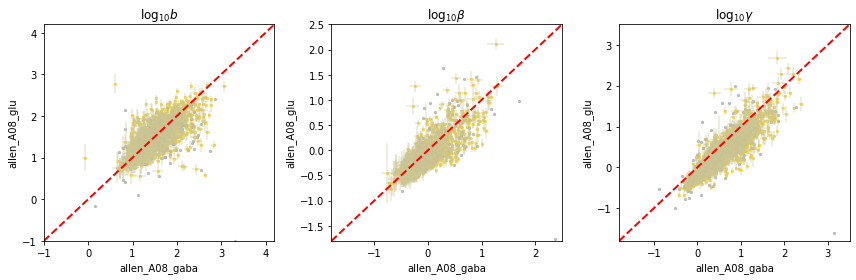

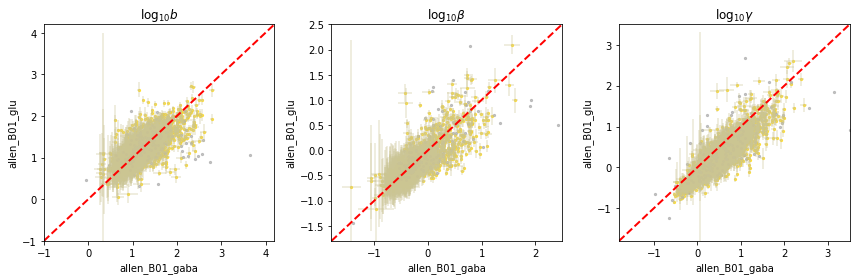

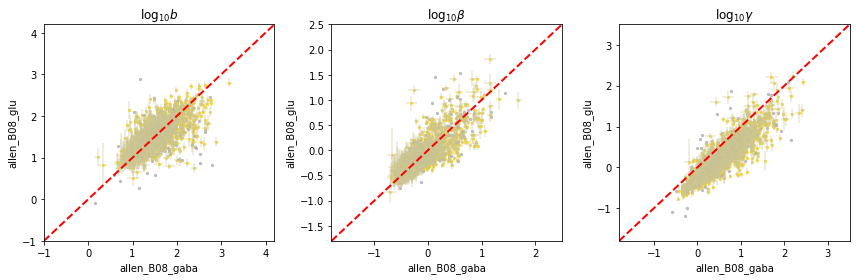

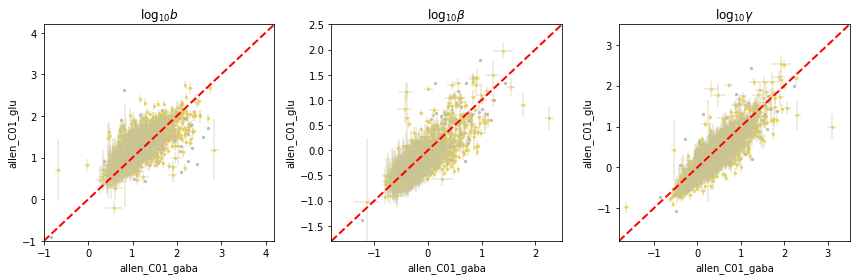

In [11]:
for i in range(4):
    plot_params_for_pair(sr_arr[i*2],sr_arr[i*2+1],\
                         distinguish_rej=True,plot_errorbars=True,meta = dataset_meta[i],xlabel = dataset_names[i*2],\
                         ylabel = dataset_names[i*2+1])

We can also compare the raw means, to ensure that they look consistent with expectations and do not exhibit unexpected batch effects that could distort the results of the $t$-test.

INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/mean_comparison_s_B08.png.


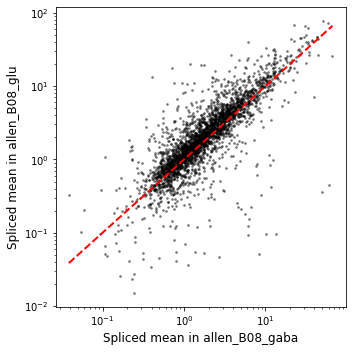

In [12]:
fig1,ax1= plt.subplots(1,1,figsize=(5,5))
i=2
m1 = [sd_arr[i*2].moments[x]['S_mean']  for x in range(sd_arr[i*2].n_genes)]
m2 = [sd_arr[i*2+1].moments[x]['S_mean'] for x in range(sd_arr[i*2+1].n_genes)]
ax1.scatter(m1,m2,3,'k',alpha=0.4)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Spliced mean in '+dataset_names[i*2],fontsize=12)
ax1.set_ylabel('Spliced mean in '+dataset_names[i*2+1],fontsize=12)
#     ax1.set_title('Spliced mean comparison')
xl = [min(m1),max(m1)]
ax1.plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()
fig_string = sr_arr[0].batch_analysis_string+'/mean_comparison_s_{}.png'.format(dataset_meta[i])
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/mean_comparison_s.png.


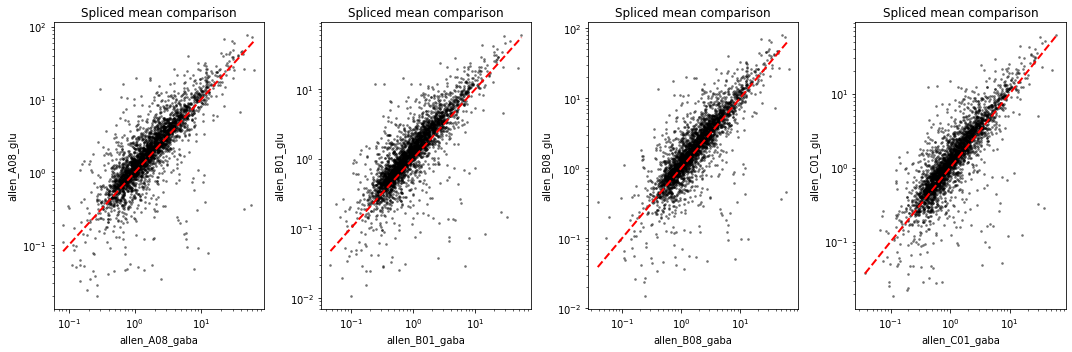

In [13]:
fig1,ax1= plt.subplots(1,len(dataset_meta),figsize=(15,5))
for i in range(len(dataset_meta)):
    m1 = [sd_arr[i*2].moments[x]['S_mean']  for x in range(sd_arr[i*2].n_genes)]
    m2 = [sd_arr[i*2+1].moments[x]['S_mean'] for x in range(sd_arr[i*2+1].n_genes)]
    ax1[i].scatter(m1,m2,3,'k',alpha=0.4)
    ax1[i].set_xscale('log')
    ax1[i].set_yscale('log')
    ax1[i].set_xlabel(dataset_names[i*2])
    ax1[i].set_ylabel(dataset_names[i*2+1])
    ax1[i].set_title('Spliced mean comparison')
    xl = [min(m1),max(m1)]
    ax1[i].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()
fig_string = sr_arr[0].batch_analysis_string+'/mean_comparison_s.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/mean_comparison_u.png.


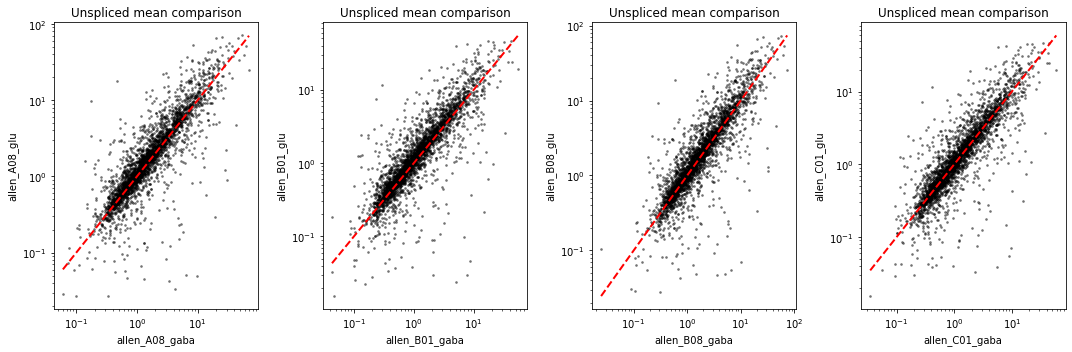

In [14]:
fig1,ax1= plt.subplots(1,len(dataset_meta),figsize=(15,5))
for i in range(len(dataset_meta)):
    m1 = [sd_arr[i*2].moments[x]['U_mean']  for x in range(sd_arr[i*2].n_genes)]
    m2 = [sd_arr[i*2+1].moments[x]['U_mean'] for x in range(sd_arr[i*2+1].n_genes)]
    ax1[i].scatter(m1,m2,3,'k',alpha=0.4)
    ax1[i].set_xscale('log')
    ax1[i].set_yscale('log')
    ax1[i].set_xlabel(dataset_names[i*2])
    ax1[i].set_ylabel(dataset_names[i*2+1])
    ax1[i].set_title('Unspliced mean comparison')
    xl = [min(m1),max(m1)]
    ax1[i].plot(xl,xl,'r--',linewidth=2)
fig1.tight_layout()
fig_string = sr_arr[0].batch_analysis_string+'/mean_comparison_u.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))


## Differential regulation analysis

We load in the parameters for each dataset and build a simple linear model for the relationship between the MLEs in the two cell types. This model induces a Gaussian distribution of residuals. By fitting this model, then removing putative "outliers" beyond $p=0.001$, we identify a self-consistent residual distribution and a population of differentially regulated genes for each dataset and parameter.

INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/parameter_residuals_A08.png.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/parameter_residuals_B01.png.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/parameter_residuals_B08.png.
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/parameter_residuals_C01.png.


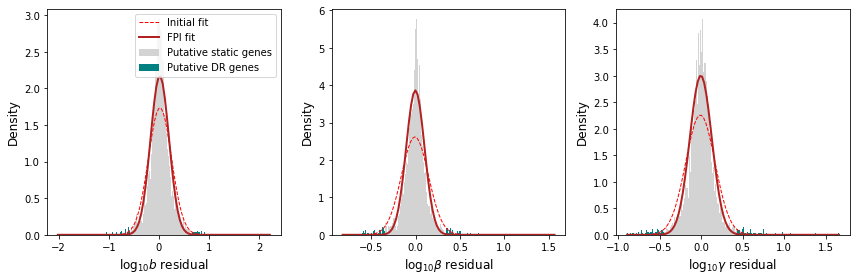

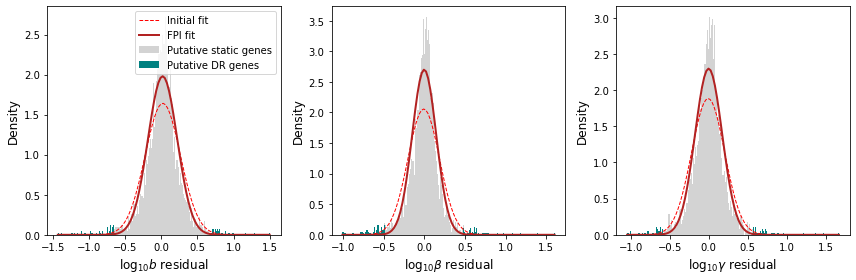

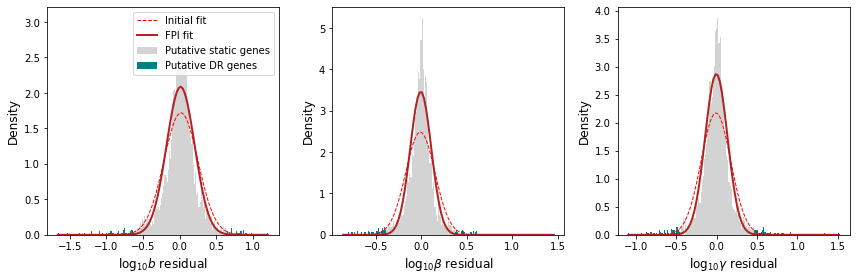

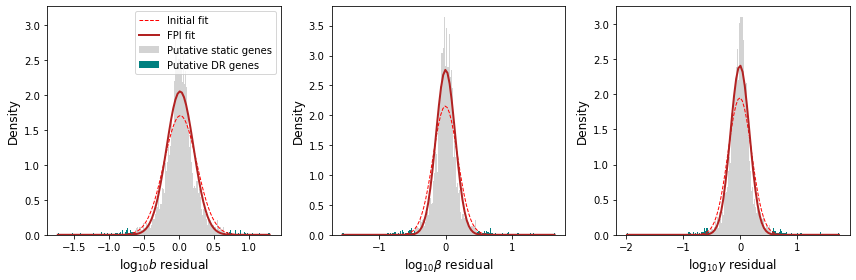

In [15]:
dr_analysis = []
for i in range(len(dataset_meta)):
    dr_analysis.append(compute_diffreg(sr_arr[i*2],sr_arr[i*2+1],viz=True,modeltype='id',meta=dataset_meta[i],use_sigma=True))

In [16]:
dr_params = np.asarray([x[1] for x in dr_analysis])

In [17]:
dr_params.shape

(4, 3, 3000)

Some 60-130 genes are modulated, out of the 3000 under analysis, which matches the usual intuition that "marker genes" are rare.

In [18]:
dr_params.sum(2)

array([[ 67, 130,  96],
       [ 70, 101,  72],
       [ 65, 113, 100],
       [ 64,  80,  69]])

The model we fit does not involve the burst frequency: we set the parameter to 1, and express the splicing and degradation rates in the units of this frequency. However, we can still identify a signature of burst frequency modulation. If both the splicing rate and the degradation rate are identified as modulated, and their modulation is in the same direction with the same magnitude, we can propose that they are *actually* static: what is being modified is the burst frequency.

INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/frequency_modulation_hist.png.


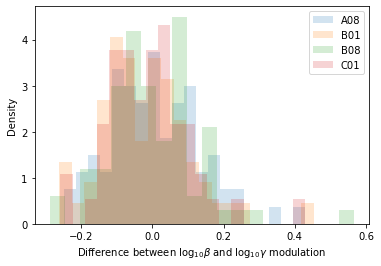

In [19]:
gf=[]
for i in range(len(dataset_meta)):
    gf_ = np.logical_and(dr_params[i,2],dr_params[i,1])
    plt.hist((dr_analysis[i][3][1]-dr_analysis[i][3][2])[gf_],alpha=0.2,label=dataset_meta[i],density=True,bins=20)
    gf.append(gf_)
gf = np.asarray(gf)
plt.legend()
plt.ylabel('Density')
plt.xlabel(r'Difference between $\log_{10}\beta$ and $\log_{10}\gamma$ modulation')
fig_string = sr_arr[0].batch_analysis_string+'/frequency_modulation_hist.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))

INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/frequency_modulation.png.


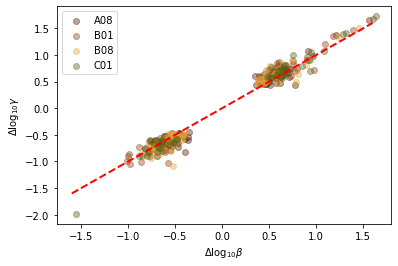

In [20]:

#https://github.com/BlakeRMills/MetBrewer
Degas=("#591d06", "#96410e", "#e5a335", "#556219", "#418979", "#2b614e", "#053c29")

gf=[]
for i in range(len(dataset_meta)):
    gf_ = np.logical_and(dr_params[i,2],dr_params[i,1])
    plt.scatter(dr_analysis[i][3][1][gf_],dr_analysis[i][3][2][gf_],alpha=0.4,label=dataset_meta[i],color=Degas[i])
    gf.append(gf_)
xl = [-1.6,1.6]
plt.plot(xl,xl,'r--',linewidth=2)
gf = np.asarray(gf)
plt.legend()
plt.ylabel(r'$\Delta \log_{10}\gamma$')
plt.xlabel(r'$\Delta \log_{10}\beta$')
fig_string = sr_arr[0].batch_analysis_string+'/frequency_modulation.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))

This speculation appears to be borne out by the data: simultaneous modulation of these rates, where identified, is typically of the within a quarter of an order of magnitude.

In [21]:
gf.sum(1)

array([79, 62, 78, 54])

We can plot distributions possibly induced by this modulation strategy.

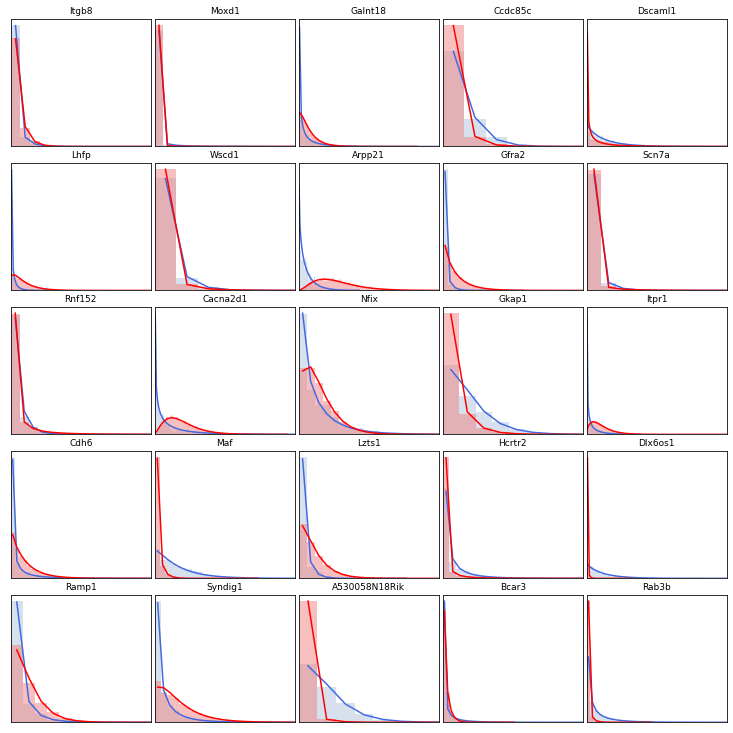

In [22]:
i=1
compare_gene_distributions([sr_arr[i*2],sr_arr[i*2+1]], [sd_arr[i*2],sd_arr[i*2+1]],
                          genes_to_plot=gf[i],marg='nascent',logscale=False)

Alternatively, we can find differentially expressed genes by a $t$-test and an analogous fixed-point iteration procedure on the log-means. We correct the $t$-test using the knee plot filtering procedure and log1pPF.

In [23]:
thr = [2e3, 3e3, 2e3, 3e3, 3e3, 3e3, 2e3, 3e3]

/home/ggorin/projects/seq-cme-technoise/analysis.py:642: RuntimeWarning: divide by zero encountered in log10
  if viz:


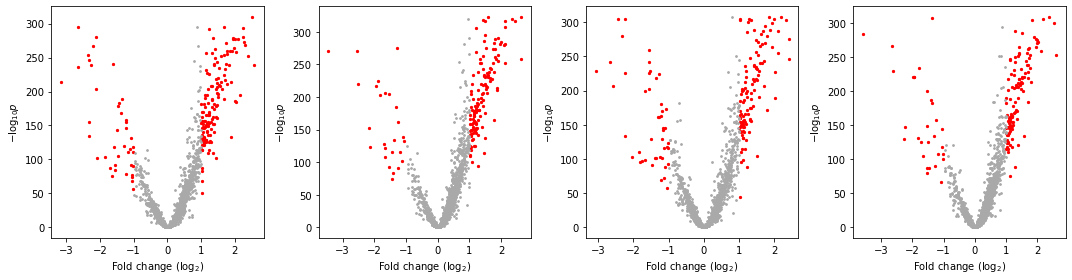

In [148]:
de_ttest = []
fc = []

fig1,ax1 = plt.subplots(1,len(dataset_meta),figsize=(15,4))
for i in range(len(dataset_meta)):
    gf_ttest,fc_ = compute_diffexp(sd_arr[i*2],sd_arr[i*2+1],lognormalize=True,viz=True,method='ttest',
                                    knee_thr=[thr[i*2],thr[i*2+1]],fc_thr=1,ax1=ax1[i],pval_thr=0.05)
    de_ttest.append(gf_ttest)
    fc.append(fc_)
    
fig1.tight_layout()
de_ttest=np.asarray(de_ttest)
fc=np.asarray(fc)

In [353]:
dataset_names

['allen_A08_gaba',
 'allen_A08_glu',
 'allen_B01_gaba',
 'allen_B01_glu',
 'allen_B08_gaba',
 'allen_B08_glu',
 'allen_C01_gaba',
 'allen_C01_glu']

In [317]:
n_phys_pars = sr_arr[0].sp.n_phys_pars
n_genes = sr_arr[0].n_genes
par_vals_ = np.zeros((2,len(dataset_meta),n_genes,n_phys_pars))
for i in range(len(dataset_meta)):
    par_vals_[0,i,:,:] = sr_arr[i*2].phys_optimum
    par_vals_[1,i,:,:] = sr_arr[i*2+1].phys_optimum
    

In [318]:
offsets = []
for i in range(n_phys_pars):
    data = par_vals_[:,:,:,i].reshape((8,3000))
    m1 = data[0]
    offsets_ = []
    for j in range(1,n_datasets):
        m2 = data[j]
        offsets_.append(diffreg_fpi(m1,m2,param_names[i],viz=False)[1])
    offsets.append(offsets_)
offsets = np.asarray(offsets).squeeze()

In [319]:
offsets = np.hstack((np.zeros(n_phys_pars)[:,None],offsets))

In [320]:
offsets = np.reshape(offsets.T,(2,4,n_phys_pars))

In [325]:
par_vals = par_vals_ - offsets[:,:,None,:]

In [326]:
par_vals.shape

(2, 4, 3000, 3)

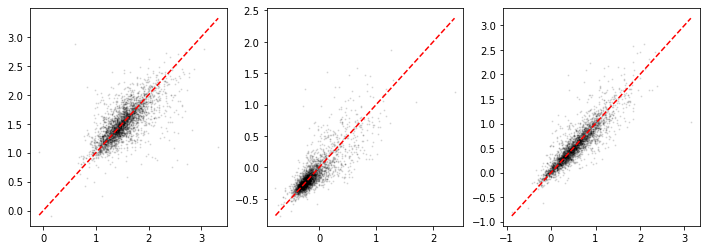

In [356]:

pval_thr = 0.05/n_genes

fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
p =  []

j = 2
for i in range(n_phys_pars):
    x = par_vals[0,0,:,i]
    y = par_vals[1,2,:,i]
    ax1[i].scatter(x,y,alpha=0.1,s=1,c='k')
    xl = [min(x),max(x)]
    ax1[i].plot(xl,xl,'r--')


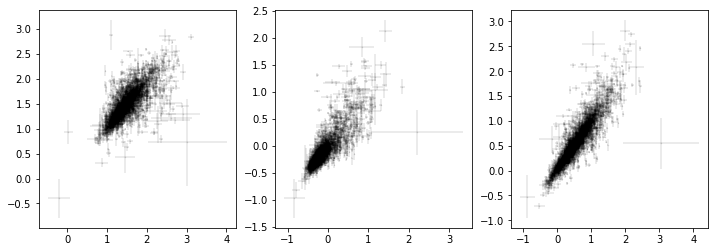

In [357]:

pval_thr = 0.05/n_genes

fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
p =  []
for i in range(n_phys_pars):
    ax1[i].errorbar(par_vals[0,:,:,i].mean(0),par_vals[1,:,:,i].mean(0),
                     par_vals[0,:,:,i].std(0),par_vals[1,:,:,i].std(0),'k.',alpha=0.1,markersize=1)
    p_ = np.zeros(n_genes)
    for j in range(n_genes):
        p_[j] = scipy.stats.ttest_ind(par_vals[0,:,j,i],par_vals[1,:,j,i],equal_var=False)[1]
    p.append(p_)
#     ax1[i].scatter(par_vals[0,:,:,i].mean(0),par_vals[1,:,:,i].mean(0),color=Degas[1],s=2)
    

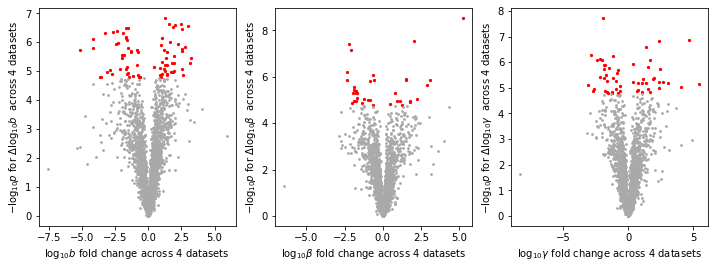

In [378]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
gf_ = []
for i in range(n_phys_pars):
    fc_d = (par_vals[1,:,:,i]-par_vals[0,:,:,i]).mean(0)
    gf = p[i]<pval_thr
    p_ = -np.log10(p[i])
    ax1[i].scatter(fc_d[gf]/np.log10(2),p_[gf],color='r',s=5)
    ax1[i].scatter(fc_d[~gf]/np.log10(2),p_[~gf],color='darkgray',s=3)
    gf_.append(gf)
    ax1[i].set_ylabel(r'$-\log_{10} p$ for $\Delta$'+param_names[i]+'  across 4 datasets')
    ax1[i].set_xlabel(param_names[i]+' fold change across 4 datasets')

gf = np.asarray(gf_)

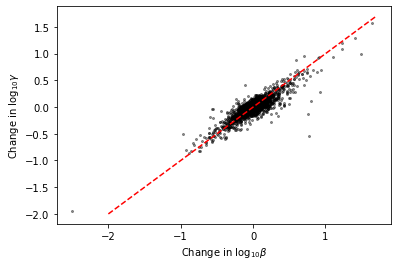

In [380]:
plt.scatter((par_vals[1,:,:,2]-par_vals[0,:,:,2]).mean(0),(par_vals[1,:,:,1]-par_vals[0,:,:,1]).mean(0),4,'k',alpha=0.4)
plt.xlabel('Change in '+param_names[1])
plt.ylabel('Change in '+param_names[2])
xl = [-2,1.7]
plt.plot(xl,xl,'r--')

In [382]:
g___ = gf[1] & gf[2]

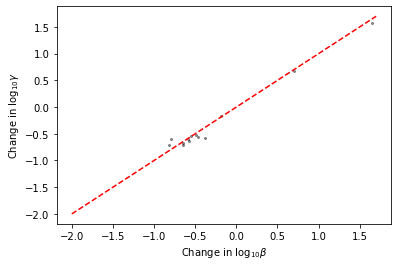

In [383]:
plt.scatter((par_vals[1,:,:,2]-par_vals[0,:,:,2]).mean(0)[g___],(par_vals[1,:,:,1]-par_vals[0,:,:,1]).mean(0)[g___],4,'k',alpha=0.4)
plt.xlabel('Change in '+param_names[1])
plt.ylabel('Change in '+param_names[2])
xl = [-2,1.7]
plt.plot(xl,xl,'r--')

In [363]:
fc_d

array([ 0.15023093,  0.09722813,  0.01154532, ..., -0.13142236,
       -0.02023321, -0.00830737])

In [364]:
gf.sum(1)

array([78, 36, 55])

In [365]:
(gf[1] & gf[2]).sum()

13

In [366]:
gn[gf[0]]

array(['Klhl3', 'Thra', 'Prkcb', 'Nek7', 'Rnf165', 'Atp2b4', 'Daam1',
       'Atf6', 'Mpped1', 'Angpt1', 'Gpm6b', 'Stx1a', 'Tmem130', 'Galnt18',
       'Rbms3', 'Stum', 'Bhlhb9', 'Gabra1', '2900026A02Rik', 'Inpp5f',
       'Cacna2d2', 'Ece1', 'Dtnb', 'Mmd', 'Kcnn2', 'Tmem44', 'Klf9',
       'Klf5', 'Ppp1r9a', 'Dgkb', 'Diras2', 'Arhgef9', 'Nectin1', 'Sv2c',
       'Cadps2', 'Synpr', 'Nwd2', 'Phka2', 'Wasf1', 'Nfix', 'Lingo1',
       'Ubr5', 'Bend6', 'Igsf9b', 'Slc9a6', 'Parm1', 'Ndst1', 'Dlg1',
       'Tox3', 'Cers6', 'Foxp1', 'Adcy2', 'Grip2', 'Pgm2l1', 'Dpysl3',
       'Dlc1', 'Slco3a1', 'Camk2a', 'Tpm3', 'Actn4', 'Cnksr2', 'Igsf21',
       'Arnt2', 'Enah', 'Xkr6', '2010300C02Rik', 'Hunk', 'Rrbp1',
       'Tnfaip8l3', 'Arhgap32', 'Dlgap4', 'Ube2e2', 'Glce', 'Fstl5',
       'Cald1', 'Prkacb', 'Rims4', 'Serpine2'], dtype='<U16')

In [367]:
gn[gf[1]]

array(['Il34', 'Galnt18', 'Nav1', 'Arpp21', 'Acvr1c', 'Gabrd', 'Cacna2d1',
       'Nectin1', 'Plcl2', 'Tnr', 'Cdh6', 'Dlg1', 'Ramp1', 'Stmn3',
       'A530058N18Rik', 'Ptprk', 'Mgat3', 'A230006K03Rik', 'Adcy2',
       '5330434G04Rik', 'Chd9', 'Ubash3b', 'Rasgrp1', 'Galnt14', 'Cacng5',
       'Tmem178b', 'Cbln2', 'Camk1d', 'C530008M17Rik', 'Mpped2',
       'Fam135b', 'Mtss1', 'Sorcs1', 'Scg3', 'Mical2', 'Mblac2'],
      dtype='<U16')

In [368]:
gn[gf[2]]

array(['Atf6', 'Galnt18', 'Rbms3', 'Gabra1', 'Inpp5f', 'Camk2d', 'Klf5',
       'Rims3', 'Trhde', 'Gabrd', 'Cacna2d1', 'Igf1', 'Cadps2', 'Thsd7a',
       'Cxxc5', 'Cdh6', 'Ndst1', 'Lzts1', 'Rcan2', 'Runx1t1', 'Ramp1',
       'Osbpl9', 'Hivep2', 'Syndig1', 'A530058N18Rik', 'Ptprk', 'Csnk1a1',
       'Adcy2', 'Ano3', 'Cep83', 'Dzank1', 'Adcyap1r1', 'Crtc3', 'Abat',
       'Cntfr', 'Drp2', 'Srgap3', 'Nyap2', 'Fnbp1l', '1110004F10Rik',
       'Galnt14', 'Hdac4', 'Spock3', 'Camk1d', 'Col25a1', 'Fam81a',
       'Wwc2', 'Mpped2', 'Baz2b', 'Prickle1', 'Fam135b', 'Sorcs1',
       'Rcan3', 'Cald1', 'Igsf3'], dtype='<U16')

In [369]:
gn[(gf[1] & gf[2])]

array(['Galnt18', 'Gabrd', 'Cacna2d1', 'Cdh6', 'Ramp1', 'A530058N18Rik',
       'Ptprk', 'Adcy2', 'Galnt14', 'Camk1d', 'Mpped2', 'Fam135b',
       'Sorcs1'], dtype='<U16')

In [163]:
param_names = sr_arr[0].model.get_log_name_str()

In [168]:
dataset_names

['allen_A08_gaba',
 'allen_A08_glu',
 'allen_B01_gaba',
 'allen_B01_glu',
 'allen_B08_gaba',
 'allen_B08_glu',
 'allen_C01_gaba',
 'allen_C01_glu']

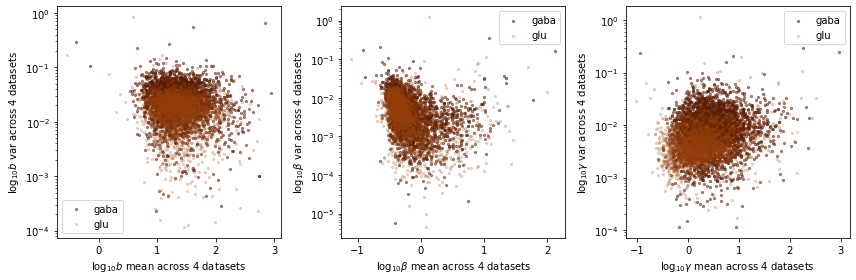

In [172]:
fig1,ax1 = plt.subplots(1,n_phys_pars,figsize=(12,4))
for i in range(n_phys_pars):

    ax1[i].scatter( (par_vals[0,:,:,i]).mean(0),(par_vals[0,:,:,i]).var(0),color=Degas[0],s=5,alpha=0.5,label='gaba')
    ax1[i].scatter( (par_vals[1,:,:,i]).mean(0),(par_vals[1,:,:,i]).var(0),color=Degas[1],s=5,alpha=0.2,label='glu')
    ax1[i].set_xlabel(param_names[i]+' mean across 4 datasets')
    ax1[i].set_yscale('log')
    ax1[i].set_ylabel(param_names[i]+' var across 4 datasets')
    ax1[i].legend()
fig1.tight_layout()


In [154]:
(p[2]<pval_thr).sum()

26

In [93]:
import importlib
importlib.reload(analysis)
from analysis import *

The $t$-test reports more than half of the genes as differentially expressed, possibly suggesting a high false positive rate.

In [149]:
de_ttest.sum(1)

array([204, 179, 189, 164])

In [26]:
dr_params.shape

(4, 3, 3000)

We can filter for genes that are *not* identified as DE, but *are* identified as DR with respect to the burst size parameter, and plot the nascent and mature distributions.

9
INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/dr_b_nas.png.


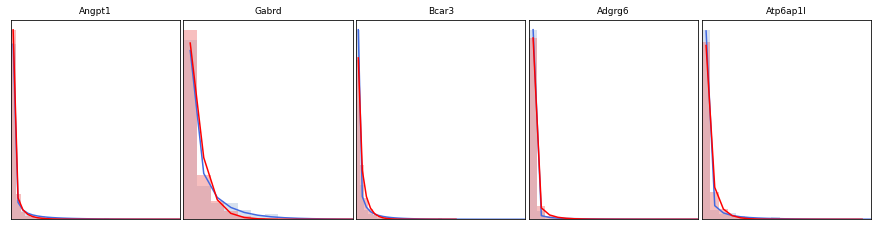

In [41]:
i=2
gf =  dr_params[:,0,:] & ~de_ttest
gf = gf[i] & ~sr_arr[i*2].rejected_genes & ~sr_arr[i*2+1].rejected_genes
print(gf.sum())
compare_gene_distributions([sr_arr[i*2],sr_arr[i*2+1]], [sd_arr[i*2],sd_arr[i*2+1]],
                          genes_to_plot=gf,marg='nascent',logscale=False,sz=(1,5),figsize=(12,3))

fig_string = sr_arr[0].batch_analysis_string+'/dr_b_nas.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))

INFO:root:Figure stored to ./fits/gg_220527_021_allen_celltypes_1/analysis_figures/dr_b_mat.png.


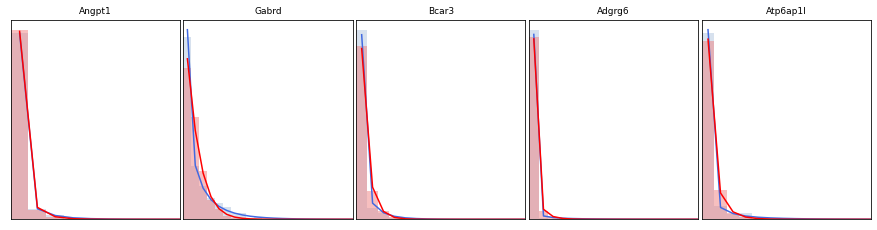

In [42]:
compare_gene_distributions([sr_arr[i*2],sr_arr[i*2+1]], [sd_arr[i*2],sd_arr[i*2+1]],
                          genes_to_plot=gf,marg='mature',logscale=False,sz=(1,5),figsize=(12,3))

fig_string = sr_arr[0].batch_analysis_string+'/dr_b_mat.png'
plt.savefig(fig_string,dpi=450)
log.info('Figure stored to {}.'.format(fig_string))

The differences are relatively subtle.

In [30]:
sr_arr[i*2].gene_names[gf]

array(['Angpt1', 'Gabrd', 'Bcar3', 'Adgrg6', 'Atp6ap1l', 'Ntn1',
       'Col25a1', 'Satb1', 'Ccn3'], dtype='<U16')

Next, we consider distributions that may show burst frequency modulation, but no mean modulation.

In [62]:
gf =  dr_params[:,2,:] & dr_params[:,1,:] &  ~de_ttest
gf = gf[i] & ~sr_arr[i*2].rejected_genes & ~sr_arr[i*2+1].rejected_genes

In [63]:
sr_arr[i*2].gene_names[gf]

array(['Il34', 'Moxd1', 'Prune2', 'Mobp', 'Galnt18', 'Dscaml1', 'Wscd1',
       'Scn7a', 'C130073E24Rik', 'Nfix', 'Gkap1', 'Cdh6', 'Hcrtr2',
       'Ramp1', 'Pld5', 'Syndig1', 'A530058N18Rik', 'Bcar3', 'Eps8',
       'Lancl3', 'Adgrg6', 'Galnt14', 'Cacng5', 'Kcnk10', 'Vwc2',
       'Sccpdh', 'Col25a1', 'Satb1', 'Slit2', 'Kcnmb4', 'Smad3', 'Scg3',
       'Esr1', 'Limk1', 'Zfhx3', 'Vwc2l', 'Rcan3', 'Sema3a'], dtype='<U16')

The very close magnitudes of inferred rate modulations support the hypothesis that the burst frequency is being controlled.

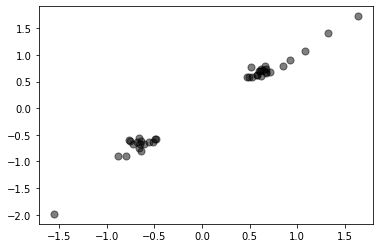

In [64]:
plt.scatter(dr_analysis[i][3][1][gf],dr_analysis[i][3][2][gf],50,'k',alpha=0.5)

Next, we can investigate the numbers of genes with particular regulatory strategies (e.g., no mean change detectable by $t$-test, but a parameter change detectable by FPI).

In [65]:
gn = sr.gene_names

In [66]:
dr_params.shape

(4, 3, 3000)

In [67]:
(de_ttest & (es>2)).sum(1)

NameError: name 'es' is not defined

In [68]:
gf = dr_params.all(0)

print(gf.sum(1))
for x in gf:
    print(gn[x])

[31 52 37]
['Klhl3' 'Unc13c' 'Nek7' 'Atp2b4' 'Atf6' 'Stx1a' 'Stum' 'Ptprm' 'Cacna2d2'
 'Klf5' 'Diras2' 'Creb3l2' 'Lingo1' 'Igsf9b' 'Ap1s2' 'Tle4' 'Slc39a10'
 'Tox3' 'Lypd6b' 'Bcar3' 'Slc8a2' 'Kctd6' 'Igsf21' 'Prkag2' 'Hunk'
 'Tnfaip8l3' 'Atp6ap1l' 'Sema3c' 'Satb1' 'Smc2' 'Sema3a']
['Nek7' 'Mpped1' 'Moxd1' 'Galnt18' 'Dscaml1' 'Lhfp' 'Wscd1' 'Arpp21'
 'Acvr1c' 'Scn7a' 'Gabrd' 'Rnf152' 'Cacna2d1' 'Ndst3' 'Nfix' 'Gkap1'
 'Phf24' 'Itpr1' 'Cdh6' 'Maf' 'Hcrtr2' 'Ramp1' 'Syndig1' 'A530058N18Rik'
 'Ptprk' 'Bcar3' 'Adcy2' 'Ano3' 'Lancl3' 'Ntng1' 'Ubash3b' 'Galnt14'
 'Kcnk10' 'Vwc2' 'Sccpdh' 'Col25a1' 'Mpped2' 'Satb1' 'Slit2' 'Fam135b'
 'Mtss1' 'Kcnmb4' 'Smad3' 'Sorcs1' 'Scg3' 'Lin7a' 'Vwc2l' 'Rcan3' 'Xylt1'
 'Sema3a' 'Doc2b' 'Igsf3']
['Moxd1' 'Galnt18' 'Dscaml1' 'Wscd1' 'Arpp21' 'Rims3' 'Scn7a' 'Cacna2d1'
 'Nfix' 'Itpr1' 'Cdh6' 'Maf' 'Hcrtr2' 'Ramp1' 'Syndig1' 'A530058N18Rik'
 'Bcar3' 'Lix1' 'Ano3' 'Lancl3' 'Adcyap1r1' 'Cntfr' 'Galnt14' 'Kcnk10'
 'Vwc2' 'Col25a1' 'Satb1' 'Slit2' 'Fam135b' 'Mtss1

Genes with mean modulation.

In [69]:
gf = de_ttest.all(0)
print(gf.sum())
print(gn[gf])

142
['Klhl3' 'Elavl2' 'Gad2' 'Prkcb' 'Atp2b4' 'Kcnb1' 'Pcsk2' 'Gpm6b' 'R3hdm1'
 'Camkk2' 'Stx1a' 'Tmem130' 'Reln' 'Rbms3' 'Arf3' 'Fut9' 'Cap2' 'Khdrbs3'
 '2900026A02Rik' 'Inpp5f' 'Adgrb1' 'Dgkz' 'Sorl1' 'Pak1' 'Mmd' 'Rbfox3'
 'Arpp21' 'Ngef' 'Klf9' 'Acvr1c' 'Gfra2' 'Ppp1r9a' 'Sirpa' 'Rap1gap2'
 'Sort1' 'Sorbs2' 'Cacna2d1' 'Diras2' 'Igf1' 'Galnt9' 'Cadps2' 'Synpr'
 'Tspan13' 'Hlf' 'Ssbp3' 'Dner' 'Rab3c' 'Gda' 'Wasf1' 'Lingo1' 'Phf24'
 'Mtpn' 'Itpr1' 'Igsf9b' 'Cx3cl1' 'Ap1s2' 'Cxxc5' 'Maf' 'Parm1' 'Dgkh'
 'Lzts1' 'Dlg1' 'Grin3a' 'Slc39a10' 'Rasgef1a' 'Dlx6os1' 'Pip5k1c'
 'Pik3r1' 'Hivep2' 'Basp1' 'Sipa1l1' 'Ryr2' 'Foxp1' 'Chn1' 'Rab3b' 'Brk1'
 'Atp2b2' 'Slc8a2' 'Epha4' 'Ptn' 'Syn1' 'Pgm2l1' 'Klf7' 'Ano3' 'Camk2a'
 'Syt7' 'Map2k1' 'Tcf4' 'Zbtb20' 'Adcyap1r1' 'Chrm1' 'Skil' 'Kcnip1'
 'Btbd8' 'Actn4' 'Gls' 'Abat' 'Nlk' 'Cnksr2' 'Kit' 'Hecw1' 'Ubash3b'
 'Klf13' '2010300C02Rik' 'Efna5' 'Trim9' 'Nol4' 'Rasgrp1' 'Arhgap32'
 'Rorb' 'Spock3' 'St3gal5' 'Slc6a1' 'Afap1' 'Fam131a' 'R3hdm2' 'Ptk2b'
 

Genes with frequency ($k_i$) modulation, overall and without mean modulation.

In [70]:
ki = dr_params[:,1,:] & dr_params[:,2,:]
print(ki.sum(1))


gf = ki.all(0)
print(gf.sum())
print(gn[gf])


[79 62 78 54]
32
['Moxd1' 'Galnt18' 'Dscaml1' 'Wscd1' 'Arpp21' 'Scn7a' 'Cacna2d1' 'Nfix'
 'Itpr1' 'Cdh6' 'Maf' 'Hcrtr2' 'Ramp1' 'Syndig1' 'A530058N18Rik' 'Bcar3'
 'Ano3' 'Lancl3' 'Galnt14' 'Kcnk10' 'Vwc2' 'Col25a1' 'Satb1' 'Slit2'
 'Fam135b' 'Mtss1' 'Kcnmb4' 'Smad3' 'Scg3' 'Rcan3' 'Sema3a' 'Igsf3']


In [71]:
gf = ki & ~de_ttest
print(gf.sum(1))
for x in gf:
    print(gn[x])

gf = gf.all(0)
print(gf.sum())
print(gn[gf])


[57 43 51 38]
['Itgb8' 'Mpped1' 'Moxd1' 'Lmo3' 'Galnt18' 'Sulf2' 'Dscaml1' 'Slc6a11'
 'Nav1' 'Wscd1' 'Trhde' 'Scn7a' 'Gabrd' 'Rnf152' 'Nfix' 'Gkap1' 'Cdh6'
 'Hcrtr2' 'Pld5' 'Syndig1' 'Ptprk' 'Bcar3' 'Lix1' 'Lancl3' 'Grm8' 'Sertm1'
 'Ntng1' 'Fgfr1' 'Galnt14' 'Fhl1' 'Cacng5' 'Kcnk10' 'Atp6ap1l' 'Vwc2'
 'Egln1' 'Sccpdh' 'Col25a1' 'Satb1' 'Slit2' 'Smc2' 'Dscam' 'Fam135b'
 'Kcnmb4' 'Smad3' 'Sorcs1' 'Scg3' 'Tgfbr2' 'Zfhx3' 'Rassf8' 'Vwc2l'
 'Rcan3' 'Stard13' 'Xylt1' 'Sema3a' 'Doc2b' 'Lmo7' 'Mblac2']
['Itgb8' 'Moxd1' 'Galnt18' 'Ccdc85c' 'Dscaml1' 'Lhfp' 'Wscd1' 'Scn7a'
 'Rnf152' 'Nfix' 'Gkap1' 'Cdh6' 'Hcrtr2' 'Ramp1' 'Syndig1' 'A530058N18Rik'
 'Bcar3' 'Lix1' 'Eps8' 'Lancl3' 'Ntng1' 'Plpp4' 'Galnt14' 'Kcnk10'
 'Atp6ap1l' 'Vwc2' 'Sccpdh' 'Col25a1' 'Satb1' 'Slit2' 'Kcnmb4' 'Smad3'
 'Scg3' 'Lin7a' 'Vwc2l' 'Rcan3' 'Xylt1' 'Sema3a' 'Rxfp1' 'Rasgef1b' 'E2f4'
 'Doc2b' 'Bard1']
['Itgb8' 'Moxd1' 'Galnt18' 'Sulf2' 'Dscaml1' 'Wscd1' 'Trhde' 'Scn7a'
 'Gabrd' 'Rnf152' 'Nectin1' 'Nfix' 'Cdh6' 'Bcl11b' 'Hcrt

Genes with $b$ modulation and no mean modulation.

In [72]:
b = dr_params[:,0,:]
print(b.sum(1))

[67 70 65 64]


In [73]:
gf = b & ~de_ttest
print(gf.sum(1))
for x in gf:
    print(gn[x])
    

gf = gf.all(0)
print(gf.sum())
print(gn[gf])


[43 50 38 45]
['Unc13c' 'Nek7' 'Mpped1' 'Angpt1' 'Ptprm' 'Tmem44' 'Klf5' 'Dgkb' 'Prex1'
 'Rgs9' 'Scn7a' 'Gabrd' 'Cemip' 'Sv2c' 'Creb3l2' 'Tle4' 'Tox3' 'Lypd6b'
 'Bcar3' 'Srrm4' 'Kctd6' 'Sntb2' 'Igsf21' 'Plpp4' 'Prkag2' 'Rnf144b'
 '1110004F10Rik' 'Hunk' 'Tnfaip8l3' 'Atp6ap1l' 'Vwc2' 'Egln1' 'Col25a1'
 'Satb1' 'Slit2' 'Smc2' 'Hmgcr' 'Nkain3' 'Man1a' 'Tsnax' 'Ccn3' 'Zfhx3'
 'Sema3a']
['Unc13c' 'Nek7' 'Mpdz' 'Atf6' 'Mpped1' 'Stum' 'Ptprm' 'Cacna2d2' 'Lrp12'
 'Tmem44' 'Klf5' 'Rims3' 'Cast' 'Dgkb' 'Ppp1r2' 'Rgs9' 'Trhde' 'Rnf152'
 'Nectin1' 'Sv2c' 'Creb3l2' 'Tle4' 'Tox3' 'Lypd6b' 'Ostm1' 'Bcar3' 'Palm'
 'Etv1' 'Kctd6' 'Igsf21' 'Prkag2' 'Nyap2' 'Hunk' 'Tnfaip8l3' 'Atp6ap1l'
 'Col25a1' 'Cux2' 'Astn2' 'Glce' 'Satb1' 'Smc2' 'Sorcs1' 'Scg3' 'Ccn3'
 'Ppp6r1' 'Fstl5' 'Sema3a' 'E2f4' 'Igsf11' 'Cdh13']
['Unc13c' 'Mpdz' 'Angpt1' 'Tmem44' 'Klf5' 'Gabrd' 'Rnf152' 'Nectin1'
 'Sv2c' 'Creb3l2' 'Tle4' 'Lypd6b' 'Disp3' 'Bcar3' 'Klf3' 'Srrm4' 'Kctd6'
 'Igsf21' 'Plpp4' 'Prkag2' 'Rnf144b' 'Adgrg6' 'Hunk' 'Tnfai

Do these strategies occur together?

In [74]:
gf = ki & b
print(gf.sum(1))
for x in gf:
    print(gn[x])

    
gf = gf.all(0)
print(gf.sum())
print(gn[gf])

[15 12 14 12]
['Mpped1' 'Scn7a' 'Gabrd' 'Maf' 'Bcar3' 'Atp6ap1l' 'Vwc2' 'Rorb' 'Egln1'
 'Col25a1' 'Satb1' 'Slit2' 'Smc2' 'Zfhx3' 'Sema3a']
['Rnf152' 'Dlx6os1' 'Bcar3' 'Rab3b' 'Atp6ap1l' 'Afap1' 'Col25a1' 'Satb1'
 'Sv2b' 'Scg3' 'Sema3a' 'E2f4']
['Gabrd' 'Rnf152' 'Nectin1' 'Cadps2' 'Maf' 'Bcar3' 'Kcnip1' 'Adgrg6'
 'Atp6ap1l' 'Egln1' 'Afap1' 'Col25a1' 'Satb1' 'Sema3a']
['Prune2' 'Mobp' 'Dlx6os1' 'Bcar3' 'Rab3b' 'Adgrg6' 'Afap1' 'Satb1' 'Scg3'
 'Esr1' 'Zfhx3' 'Sema3a']
3
['Bcar3' 'Satb1' 'Sema3a']


In [75]:
gf = ki & b & ~de_ttest
print(gf.sum(1))
for x in gf:
    print(gn[x])

[13  8 10  9]
['Mpped1' 'Scn7a' 'Gabrd' 'Bcar3' 'Atp6ap1l' 'Vwc2' 'Egln1' 'Col25a1'
 'Satb1' 'Slit2' 'Smc2' 'Zfhx3' 'Sema3a']
['Rnf152' 'Bcar3' 'Atp6ap1l' 'Col25a1' 'Satb1' 'Scg3' 'Sema3a' 'E2f4']
['Gabrd' 'Rnf152' 'Nectin1' 'Bcar3' 'Adgrg6' 'Atp6ap1l' 'Egln1' 'Col25a1'
 'Satb1' 'Sema3a']
['Prune2' 'Mobp' 'Bcar3' 'Adgrg6' 'Satb1' 'Scg3' 'Esr1' 'Zfhx3' 'Sema3a']


We can rerun some of the analysis using the genes identified as non-modulated according to the FPI on log-means method.

In [76]:
print(de_logmeanfpi.sum(1))
gf = de_logmeanfpi.all(0)
print(gf.sum())
print(gn[gf])

NameError: name 'de_logmeanfpi' is not defined

In [113]:
gf = ki & ~de_logmeanfpi
print(gf.sum(1))
for x in gf:
    print(gn[x])

gf = gf.all(0)
print(gf.sum())
print(gn[gf])


[54 32 52 30]
['Mpped1' 'Lmo3' 'Galnt18' 'Sulf2' 'Dscaml1' 'Slc6a11' 'Nav1' 'Wscd1'
 'Trhde' 'Scn7a' 'Gabrd' 'Rnf152' 'Cacna2d1' 'Nfix' 'Gkap1' 'Itpr1'
 'Rasgrf2' 'Cdh6' 'Hcrtr2' 'Ramp1' 'Pld5' 'Syndig1' 'Bcar3' 'Lix1' 'Lamp5'
 'Grm8' 'Sertm1' 'Ntng1' 'Fgfr1' 'Galnt14' 'Fhl1' 'Kcnk10' 'Atp6ap1l'
 'Egln1' 'Sccpdh' 'Col25a1' 'C530008M17Rik' 'Mpped2' 'Satb1' 'Slit2'
 'Smc2' 'Dscam' 'Fam135b' 'Kcnmb4' 'Sorcs1' 'Scg3' 'Zfhx3' 'Rassf8'
 'Vwc2l' 'Xylt1' 'Sema3a' 'Doc2b' 'Lmo7' 'Mblac2']
['Galnt18' 'Ccdc85c' 'Dscaml1' 'Wscd1' 'Scn7a' 'Rnf152' 'Cacna2d1' 'Nfix'
 'Gkap1' 'Itpr1' 'Cdh6' 'Hcrtr2' 'Ramp1' 'Syndig1' 'Bcar3' 'Lix1' 'Ntng1'
 'Kcnk10' 'Atp6ap1l' 'Sccpdh' 'Col25a1' 'Mpped2' 'Satb1' 'Slit2' 'Fam135b'
 'Kcnmb4' 'Scg3' 'Lin7a' 'Vwc2l' 'Xylt1' 'Sema3a' 'E2f4']
['Galnt18' 'Sulf2' 'Dscaml1' 'Nav1' 'Wscd1' 'Trhde' 'Scn7a' 'Gabrd'
 'Rnf152' 'Cacna2d1' 'Nectin1' 'Cadps2' 'Nfix' 'Phf24' 'Itpr1' 'Rasgrf2'
 'Cdh6' 'Bcl11b' 'Hcrtr2' 'Runx1t1' 'Ramp1' 'Syndig1' 'Bcar3' 'Lix1'
 'Lamp5' 'Socs2' 'Grm8' 

In [114]:
gf = b & ~de_logmeanfpi
print(gf.sum(1))
for x in gf:
    print(gn[x])
    

gf = gf.all(0)
print(gf.sum())
print(gn[gf])


[30 35 28 31]
['Atf6' 'Mpped1' 'Angpt1' 'R3hdm1' 'Tmem44' 'Dgkb' 'Rgs9' 'Scn7a' 'Gabrd'
 'Cemip' 'Hcn1' 'Tle4' 'Bcar3' 'Srrm4' 'Kctd6' 'Prkag2' '1110004F10Rik'
 'Atp6ap1l' 'Egln1' 'Col25a1' 'Cplx1' 'Satb1' 'Slit2' 'Smc2' 'Hmgcr'
 'Man1a' 'Tsnax' 'Ccn3' 'Zfhx3' 'Sema3a']
['Klhl3' 'Mpdz' 'Atf6' 'Mpped1' 'R3hdm1' 'Lrp12' 'Tmem44' 'Rims3' 'Cast'
 'Dgkb' 'Ppp1r2' 'Rgs9' 'Trhde' 'Rnf152' 'Nectin1' 'Tle4' 'Ostm1' 'Bcar3'
 'Palm' 'Kctd6' 'Prkag2' 'Nyap2' 'Atp6ap1l' 'Col25a1' 'Cux2' 'Astn2'
 'Glce' 'Satb1' 'Smc2' 'Sorcs1' 'Scg3' 'Ccn3' 'Ppp6r1' 'Sema3a' 'E2f4']
['Mpdz' 'Atf6' 'Angpt1' 'Tmem44' 'Gabrd' 'Rnf152' 'Nectin1' 'Cadps2'
 'Tle4' 'Disp3' 'Bcar3' 'Klf3' 'Srrm4' 'Kctd6' 'Prkag2' 'Adgrg6'
 'Atp6ap1l' 'Ntn1' 'Egln1' 'Col25a1' 'Astn2' 'Satb1' 'Smc2' 'Hmgcr'
 'Man1a' 'Ccn3' 'Zfhx3' 'Sema3a']
['Mpdz' 'Atf6' 'Mpped1' 'Angpt1' 'Prune2' 'R3hdm1' 'Mobp' 'Lrp12' 'Dgkb'
 'Ppp1r2' 'Trhde' 'Nectin1' 'Ndst3' 'Tle4' 'Slc39a10' 'Runx1t1' 'Ostm1'
 'Bcar3' 'Irs1' 'Kctd6' 'Prkag2' 'Nyap2' 'Adgrg6' 'Atp6ap1l'

filtered ttest

In [128]:
de_ttest_f = (de_ttest & (es>2))
print(de_ttest_f.sum(1))
gf = de_ttest_f.all(0)
print(gf.sum())
print(gn[gf])

[433 346 413 317]
283
['Klhl3' 'Mal2' 'Elavl2' 'Gad2' 'Prkcb' 'Scn2a' 'Selenow' 'Atp2b4' 'Prkcg'
 'Slc2a13' 'Arl8a' 'Kcnb1' 'Dclk1' 'Pcsk2' 'Cadm3' 'Gap43' 'Gpm6b'
 'Atp1a3' 'Grin2b' 'R3hdm1' 'Camkk2' 'Stx1a' 'Tmem130' 'Reln' 'Napb'
 'Msi2' 'Fxyd6' 'Rbms3' 'Arf3' 'Cacna1a' 'Dlg4' 'Fut9' 'Cap2' 'Mbnl2'
 'Khdrbs3' 'Pkig' 'Inpp5f' 'Adgrb1' 'Ppm1l' 'St13' 'Dgkz' 'Mapk1' 'Plec'
 'Actr2' 'Sorl1' 'Pak1' 'Sptbn1' 'Mmd' 'Rbfox3' 'Arpp21' 'Ngef' 'Klf9'
 'Acvr1c' 'Fam126b' 'Gfra2' 'Ppp1r9a' 'Sirpa' 'Tubb4a' 'Rap1gap2' 'Sort1'
 'Syt13' 'Qk' 'Sorbs2' 'Hmgb1' 'Cacna2d1' 'Diras2' 'Wasl' 'Arhgef9' 'Igf1'
 'Sbno1' 'Galnt9' 'Tmem30a' 'Synpr' 'Tspan13' 'Hlf' 'Ssbp3' 'Smim13'
 'Dner' 'Rab3c' 'Nrsn1' 'Scn8a' 'Kif1b' 'Slc8a1' 'Cabp1' 'Cyfip2' 'Atp1b1'
 'Gda' 'Gria2' 'Hcn1' 'Fbxl16' 'Wasf1' 'Pgbd5' 'Camta2' 'Lingo1' 'Phf24'
 'Add2' 'Cd47' 'Atp2a2' 'Snap91' 'Mtpn' 'Itpr1' 'Igsf9b' 'Cx3cl1' 'Acsl4'
 'Ap1s2' 'Cxxc5' 'Maf' 'Parm1' 'Gpm6a' 'Ptprs' 'Tle4' 'Dgkh' 'Nrcam'
 'Lzts1' 'Dlg1' 'Grin3a' 'Micu3' 'Ywhag' 'Sl

In [129]:
gf = ki & ~de_ttest_f
print(gf.sum(1))
for x in gf:
    print(gn[x])

gf = gf.all(0)
print(gf.sum())
print(gn[gf])


[57 44 54 40]
['Itgb8' 'Mpped1' 'Moxd1' 'Lmo3' 'Galnt18' 'Sulf2' 'Dscaml1' 'Slc6a11'
 'Wscd1' 'Trhde' 'Scn7a' 'Gabrd' 'Rnf152' 'Nfix' 'Gkap1' 'Cdh6' 'Hcrtr2'
 'Pld5' 'Syndig1' 'A530058N18Rik' 'Ptprk' 'Bcar3' 'Lix1' 'Lancl3' 'Grm8'
 'Sertm1' 'Ntng1' 'Fgfr1' 'Galnt14' 'Fhl1' 'Cacng5' 'Kcnk10' 'Atp6ap1l'
 'Vwc2' 'Egln1' 'Sccpdh' 'Col25a1' 'Satb1' 'Slit2' 'Smc2' 'Dscam'
 'Fam135b' 'Kcnmb4' 'Smad3' 'Sorcs1' 'Scg3' 'Tgfbr2' 'Zfhx3' 'Rassf8'
 'Vwc2l' 'Rcan3' 'Stard13' 'Xylt1' 'Sema3a' 'Doc2b' 'Lmo7' 'Mblac2']
['Itgb8' 'Moxd1' 'Galnt18' 'Ccdc85c' 'Dscaml1' 'Lhfp' 'Wscd1' 'Scn7a'
 'Rnf152' 'Nfix' 'Gkap1' 'Cdh6' 'Hcrtr2' 'Ramp1' 'Syndig1' 'A530058N18Rik'
 'Bcar3' 'Lix1' 'Eps8' 'Lancl3' 'Ntng1' 'Plpp4' 'Galnt14' 'Kcnk10'
 'Atp6ap1l' 'Vwc2' 'Sccpdh' 'Col25a1' 'Mpped2' 'Satb1' 'Slit2' 'Mtss1'
 'Kcnmb4' 'Smad3' 'Scg3' 'Lin7a' 'Vwc2l' 'Rcan3' 'Xylt1' 'Sema3a'
 'Rasgef1b' 'E2f4' 'Doc2b' 'Bard1']
['Itgb8' 'Moxd1' 'Galnt18' 'Sulf2' 'Dscaml1' 'Wscd1' 'Trhde' 'Scn7a'
 'Gabrd' 'Rnf152' 'Nectin1' 'Cadps2' '

In [130]:
gf = b & ~de_ttest_f
print(gf.sum(1))
for x in gf:
    print(gn[x])
    

gf = gf.all(0)
print(gf.sum())
print(gn[gf])


[37 46 35 44]
['Unc13c' 'Mpped1' 'Angpt1' 'Ptprm' 'Tmem44' 'Klf5' 'Prex1' 'Rgs9' 'Scn7a'
 'Gabrd' 'Cemip' 'Creb3l2' 'Tox3' 'Lypd6b' 'Bcar3' 'Srrm4' 'Kctd6' 'Sntb2'
 'Igsf21' 'Plpp4' 'Prkag2' 'Rnf144b' '1110004F10Rik' 'Hunk' 'Tnfaip8l3'
 'Atp6ap1l' 'Vwc2' 'Egln1' 'Col25a1' 'Satb1' 'Slit2' 'Smc2' 'Nkain3'
 'Man1a' 'Ccn3' 'Zfhx3' 'Sema3a']
['Unc13c' 'Nek7' 'Mpdz' 'Atf6' 'Mpped1' 'Stum' 'Ptprm' 'Cacna2d2' 'Lrp12'
 'Tmem44' 'Klf5' 'Rims3' 'Cast' 'Ppp1r2' 'Rgs9' 'Trhde' 'Rnf152' 'Nectin1'
 'Sv2c' 'Creb3l2' 'Tox3' 'Lypd6b' 'Ostm1' 'Bcar3' 'Palm' 'Kctd6' 'Igsf21'
 'Prkag2' 'Nyap2' 'Hunk' 'Tnfaip8l3' 'Atp6ap1l' 'Col25a1' 'Astn2' 'Glce'
 'Satb1' 'Smc2' 'Sorcs1' 'Scg3' 'Ccn3' 'Ppp6r1' 'Fstl5' 'Sema3a' 'E2f4'
 'Igsf11' 'Cdh13']
['Unc13c' 'Mpdz' 'Angpt1' 'Tmem44' 'Klf5' 'Gabrd' 'Rnf152' 'Nectin1'
 'Cadps2' 'Creb3l2' 'Lypd6b' 'Disp3' 'Bcar3' 'Klf3' 'Srrm4' 'Kctd6'
 'Igsf21' 'Plpp4' 'Prkag2' 'Rnf144b' 'Adgrg6' 'Hunk' 'Tnfaip8l3'
 'Atp6ap1l' 'Ntn1' 'Egln1' 'Col25a1' 'Astn2' 'Satb1' 'Smc2' 'Nkain3'
 'M

In [143]:
de_ttest_f.sum(1)

array([433, 346, 413, 317])

In [140]:
dr_params.any(1).sum(1)

array([187, 157, 181, 139])

In [141]:
(de_ttest_f & dr_params.any(1)).sum(1)

array([57, 43, 60, 39])

In [136]:
(de_ttest_f & ~dr_params.any(1)).sum(1)

array([376, 303, 353, 278])

In [147]:
de_ttest_f.all(0).sum()

283

In [153]:
dr_params.any(1).all(0).sum()

88

In [155]:
(de_ttest_f & dr_params.any(1)).all(0).sum()

22

In [34]:
t2 = time.time()
print('Runtime: {:.0f} seconds.'.format(t2-t1))

Runtime: 59 seconds.
